##### Imports

In [81]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, vgg16
from torchsummary import summary
import os
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

##### Load Datasets

In [82]:
# Transform to resize the images to 32 x 32 and convert to tensor
preProc = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

preProc2 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class DL:
    def __init__(self, dataset, name):
        self.dataloader = DataLoader(dataset, batch_size=50, shuffle=True)
        self.name = name

# Download the datasets
mnist_raw_data = datasets.MNIST('./datasets/mnist', train=True, download=True, transform=preProc)
fmnist_raw_data = datasets.FashionMNIST('./datasets/fashion-mnist', train=True, download=True, transform=preProc)
cifar10_raw_data = datasets.CIFAR10('./datasets/cifar10', train=True, download=True, transform=preProc2)
mnist_raw_test = datasets.MNIST('./datasets/mnist', train=False, download=True, transform=preProc)
fmnist_raw_test = datasets.FashionMNIST('./datasets/fashion-mnist', train=False, download=True, transform=preProc)
cifar10_raw_test = datasets.CIFAR10('./datasets/cifar10', train=False, download=True, transform=preProc2)

mnist_len = len(mnist_raw_data)
fmnist_len = len(fmnist_raw_data)
cifar10_len = len(cifar10_raw_data)

# Split data into training and validation sets (90%, 10%)
mnist_train_set, mnist_val_set = random_split(mnist_raw_data, [int(0.9 * mnist_len), mnist_len - int(0.9 * mnist_len)])
fmnist_train_set, fmnist_val_set = random_split(fmnist_raw_data, [int(0.9 * fmnist_len), fmnist_len - int(0.9 * fmnist_len)])
cifar10_train_set, cifar10_val_set = random_split(cifar10_raw_data, [int(0.9 * cifar10_len), cifar10_len - int(0.9 * cifar10_len)])

# Create data loaders for training, validation, and testing sets
mnist_train_dl = DL(mnist_train_set, 'MNIST')
mnist_val_dl = DL(mnist_val_set, 'MNIST')
mnist_test_dl = DL(mnist_raw_test, 'MNIST')
fmnist_train_dl = DL(fmnist_train_set, 'Fashion_MNIST')
fmnist_val_dl = DL(fmnist_val_set, 'Fashion_MNIST')
fmnist_test_dl = DL(fmnist_raw_test, 'Fashion_MNIST')
cifar10_train_dl = DL(cifar10_train_set, 'CIFAR10')
cifar10_val_dl = DL(cifar10_val_set, 'CIFAR10')
cifar10_test_dl = DL(cifar10_raw_test, 'CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


##### Dataset Samples

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
torch.Size([60000, 28, 28])


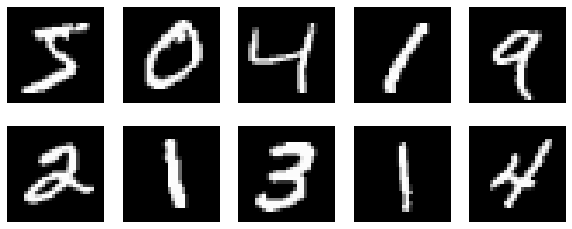

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./datasets/fashion-mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
torch.Size([60000, 28, 28])


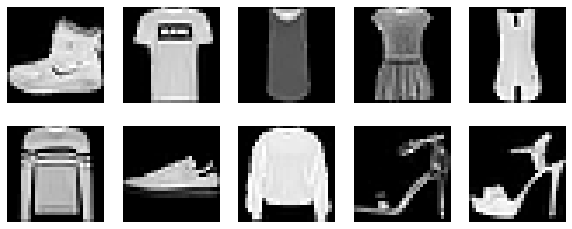

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
(50000, 32, 32, 3)


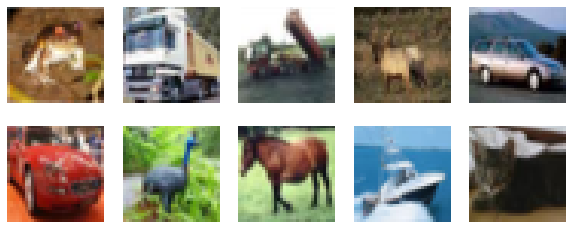

In [83]:
def plot(dataset, cmap):
  fig, ax = plt.subplots(2, 5, figsize=(10,4))
  for r in range(0, 2):
    for c in range(0, 5):
      ax[r, c].imshow(dataset.data[r*5+c], cmap=cmap)
      ax[r, c].axis('off')
  plt.show()

print(mnist_raw_data)
print(mnist_raw_data.data.shape)
plot(mnist_raw_data, 'gray')

print(fmnist_raw_data)
print(fmnist_raw_data.data.shape)
plot(fmnist_raw_data, 'gray')

print(cifar10_raw_data)
print(cifar10_raw_data.data.shape)
plot(cifar10_raw_data, 'brg')

##### Define Models

In [84]:
class MLP(nn.Module):
  def __init__(self, in_channels):
    super(MLP, self).__init__()
    self.name = 'MLP'
    self.d1 = nn.Linear(32*32*in_channels, 256)
    self.d2 = nn.Linear(256, 128)
    self.d3 = nn.Linear(128, 64)
    self.d4 = nn.Linear(64, 10)
    self.relu = nn.ReLU()
    self.out = nn.Softmax(dim=1)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.d1(x)
    x = self.relu(x)
    x = self.d2(x)
    x = self.relu(x)
    x = self.d3(x)
    x = self.relu(x)
    x = self.d4(x)
    return self.out(x)
print('MLP')
summary(MLP(3).to('cuda'), (3, 32, 32))

class LeNet(nn.Module):
  def __init__(self, in_channels):
    super(LeNet, self).__init__()
    self.name = 'LeNet'
    self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.relu = nn.ReLU()
    self.out = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.c1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.c2(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return self.out(x)
print('LeNet')
summary(LeNet(3).to('cuda'), (3, 32, 32))

class Custom(nn.Module):
  def __init__(self, in_channels):
    super(Custom, self).__init__()
    self.name = 'Custom'
    self.c1 = nn.Linear(32*32*in_channels, 392)
    self.c2 = nn.Linear(392, 98)
    self.c3 = nn.Linear(98, 10)
    self.relu = nn.ReLU()
    self.out = nn.Softmax(dim=1)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.c1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.relu(x)
    x = self.c3(x)
    return self.out(x)
print('Custom')
summary(Custom(3).to('cuda'), (3, 32, 32))

class Custom2(nn.Module):
  def __init__(self, in_channels):
    super(Custom2, self).__init__()
    self.name = 'Custom2'
    self.c1 = nn.Linear(32*32*in_channels, 1024)
    self.c2 = nn.Linear(1024, 512)
    self.c3 = nn.Linear(512, 64)
    self.c4 = nn.Linear(64, 64)
    self.c5 = nn.Linear(64, 10)
    self.relu = nn.ReLU()
    self.out = nn.Softmax(dim=1)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.c1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.relu(x)
    x = self.c3(x)
    x = self.relu(x)
    x = self.c4(x)
    x = self.relu(x)
    x = self.c5(x)
    return self.out(x)
print('Custom2')
summary(Custom2(3).to('cuda'), (3, 32, 32))

# class VGG16(nn.Module):
#   def __init__(self, in_channels):
#     super(VGG16, self).__init__()
#     self.name = 'VGG16'
#     self.model = vgg16(num_classes=10)
#     self.model.features[0] = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=8)
#     self.out = nn.Softmax(dim=1)

#   def forward(self, x):
#     x = self.model(x)
#     return self.out(x)

# class ResNet18(nn.Module):
#   def __init__(self, in_channels):
#     super(ResNet18, self).__init__()
#     self.name = 'ResNet18'
#     self.model = resnet18(num_classes=10)
#     self.model.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=96)
#     self.out = nn.Softmax(dim=1)

#   def forward(self, x):
#     self.model(x)
#     return self.out(x)

MLP
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
           Softmax-8                   [-1, 10]               0
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.16
Estimated Total Size (MB): 3.18
----------------------------------------------------------------
LeNet
--------------------------------

##### Train Models

In [85]:
def getDevice():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def drawIntermediate(trainHist, testHist, accHist, Mname, Dname):
  fig = plt.figure()
  fig.suptitle(f'{Mname} CNN Using {Dname} Dataset')

  loss = fig.add_subplot(211)
  loss.plot(trainHist, label='Training Loss', color='green')
  loss.plot(testHist, label='Validation Loss', color='blue')
  loss.title.set_text('Loss')
  loss.legend()

  acc = fig.add_subplot(212)
  acc.plot(accHist, label='Validation Accuracy', color='red')
  acc.title.set_text('Accuracy')
  acc.set_ylim(0, 1)
  acc.legend()

  plt.tight_layout()
  plt.show()

def trainModel(model, train_dl, val_dl, num_epochs=25, learning_rate=.001, device=getDevice()):
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), learning_rate)
  # optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
  criterion = nn.CrossEntropyLoss()

  Mname = model.name
  Dname = train_dl.name
  train_dl = train_dl.dataloader
  val_dl = val_dl.dataloader

  lastEpoch = 0
  writer = SummaryWriter()
  train_loss_hist, val_loss_hist, acc_hist = [], [], []

  def printEpochSummary(epoch, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}, Validation accuracy: {val_acc * 100:.2f}%")

  def train():
    model.train()

    total_train_loss = 0

    for batch, (x, y) in enumerate(train_dl):
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()
      preds = model(x)
      loss = criterion(preds, y)
      total_train_loss += loss.item()
      
      loss.backward()
      optimizer.step()

    total_train_loss = total_train_loss / (batch + 1)
    return total_train_loss

  def test():
    model.eval()

    total_val_loss = 0
    total = 0
    
    for batch, (x, y) in enumerate(val_dl):
      x, y = x.to(device), y.to(device)

      preds = model(x)
      total_val_loss += criterion(preds, y).item()

      for i, p in enumerate(preds):
        if y[i] == p.argmax():
          total += 1

    total_val_loss = total_val_loss / (batch + 1) 
    accuracy = total / len(val_dl.dataset)
    return total_val_loss, accuracy

  print(f'Beginning training on {Mname} NN with {Dname} dataset')
  print(f'Epochs: {num_epochs}, Learning Rate: {learning_rate}')

  if os.path.exists(f'./checkpoints/{Mname}_{Dname}_checkpoint.pth'):
    print('Resuming from last checkpoint...')
    checkpoint = torch.load(f'{Mname}_{Dname}_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss_hist = checkpoint['train_loss']
    val_loss_hist = checkpoint['val_loss']
    acc_hist = checkpoint['accuracy']
    for i in range(epoch + 1):
      printEpochSummary(i, train_loss_hist[i], val_loss_hist[i], acc_hist[i])
    lastEpoch = epoch + 1

  for epoch in range(lastEpoch, num_epochs):
    total_train_loss = train()
    total_val_loss, accuracy = test()

    writer.add_scalar("Loss/Training", total_train_loss, epoch)
    writer.add_scalar("Loss/Validation", total_val_loss, epoch)
    writer.add_scalar("Test Accuracy", accuracy, epoch)

    train_loss_hist.append(total_train_loss)
    val_loss_hist.append(total_val_loss)
    acc_hist.append(accuracy)

    printEpochSummary(epoch, total_train_loss, total_val_loss, accuracy)
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_loss': train_loss_hist,
      'val_loss': val_loss_hist,
      'accuracy': acc_hist
    }, f'./checkpoints/{Mname}_{Dname}_checkpoint.pth')
  
  print('Training complete!')
  drawIntermediate(train_loss_hist, val_loss_hist, acc_hist, Mname, Dname)
  writer.flush()
  writer.close()


##### Model Params

In [86]:
num_epochs = 25
learning_rate = .0001
device = getDevice()

#### Run The dataset on the various CNNs, test the predictions

In [87]:
def testModel(model, test_dl):
  model.eval()
  
  Mname = model.name
  Dname = test_dl.name
  test_dl = test_dl.dataloader

  num_correct = 0
  total = 0

  for batch, (x, y) in enumerate(test_dl):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      preds = model(x)
      for i, p in enumerate(preds):
        if y[i].item() == p.argmax():
          num_correct += 1
        total += 1
  
  accuracy = num_correct / total * 100
  print(f'{Mname} CNN on {Dname} dataset: {accuracy:.2f}% test accuracy\n\n')

def evalDataset(train_dl, val_dl, test_dl):
  in_channels = train_dl.dataloader.dataset[0][0].shape[0]

  # CNNs
  models = [MLP(in_channels), LeNet(in_channels), Custom(in_channels), Custom2(in_channels)]

  # Train and test each model
  for model in models:
    trainModel(model, train_dl, val_dl, num_epochs, learning_rate, device)
    testModel(model, test_dl)

##### Train & Test MNIST

Beginning training on MLP CNN with MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.63552, Validation loss: 1.55842, Validation accuracy: 90.53%
Epoch 2/25, Training loss: 1.54725, Validation loss: 1.53238, Validation accuracy: 92.92%
Epoch 3/25, Training loss: 1.53370, Validation loss: 1.53751, Validation accuracy: 92.37%
Epoch 4/25, Training loss: 1.52321, Validation loss: 1.52857, Validation accuracy: 93.25%
Epoch 5/25, Training loss: 1.51839, Validation loss: 1.50331, Validation accuracy: 95.85%
Epoch 6/25, Training loss: 1.51499, Validation loss: 1.51289, Validation accuracy: 94.82%
Epoch 7/25, Training loss: 1.51359, Validation loss: 1.51518, Validation accuracy: 94.57%
Epoch 8/25, Training loss: 1.51400, Validation loss: 1.51426, Validation accuracy: 94.72%
Epoch 9/25, Training loss: 1.51022, Validation loss: 1.52001, Validation accuracy: 94.10%
Epoch 10/25, Training loss: 1.50947, Validation loss: 1.52704, Validation 

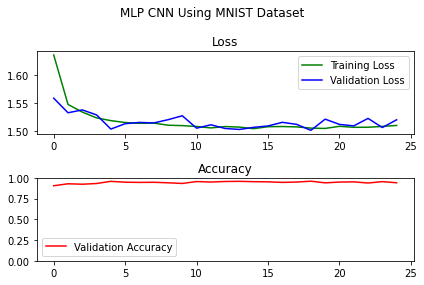

MLP CNN on MNIST dataset: 95.16% test accuracy


Beginning training on LeNet CNN with MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.60961, Validation loss: 1.50171, Validation accuracy: 96.05%
Epoch 2/25, Training loss: 1.49665, Validation loss: 1.49168, Validation accuracy: 96.97%
Epoch 3/25, Training loss: 1.49227, Validation loss: 1.48711, Validation accuracy: 97.40%
Epoch 4/25, Training loss: 1.48932, Validation loss: 1.49414, Validation accuracy: 96.67%
Epoch 5/25, Training loss: 1.48637, Validation loss: 1.49092, Validation accuracy: 97.03%
Epoch 6/25, Training loss: 1.48598, Validation loss: 1.48495, Validation accuracy: 97.57%
Epoch 7/25, Training loss: 1.48426, Validation loss: 1.48651, Validation accuracy: 97.42%
Epoch 8/25, Training loss: 1.48478, Validation loss: 1.48735, Validation accuracy: 97.40%
Epoch 9/25, Training loss: 1.48469, Validation loss: 1.48655, Validation accuracy: 97.52%
Epoch 10/25, Training l

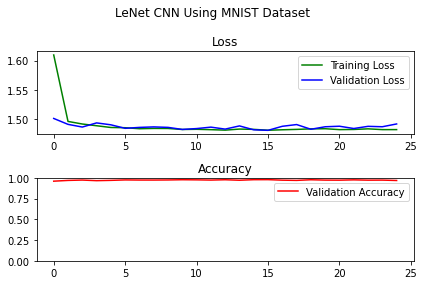

LeNet CNN on MNIST dataset: 97.43% test accuracy


Beginning training on Custom CNN with MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.70480, Validation loss: 1.64810, Validation accuracy: 81.43%
Epoch 2/25, Training loss: 1.55129, Validation loss: 1.53792, Validation accuracy: 92.55%
Epoch 3/25, Training loss: 1.52638, Validation loss: 1.51931, Validation accuracy: 94.23%
Epoch 4/25, Training loss: 1.51596, Validation loss: 1.52900, Validation accuracy: 93.22%
Epoch 5/25, Training loss: 1.51265, Validation loss: 1.51614, Validation accuracy: 94.45%
Epoch 6/25, Training loss: 1.51031, Validation loss: 1.50679, Validation accuracy: 95.47%
Epoch 7/25, Training loss: 1.50582, Validation loss: 1.51441, Validation accuracy: 94.67%
Epoch 8/25, Training loss: 1.50439, Validation loss: 1.52430, Validation accuracy: 93.77%
Epoch 9/25, Training loss: 1.50184, Validation loss: 1.50896, Validation accuracy: 95.12%
Epoch 10/25, Trainin

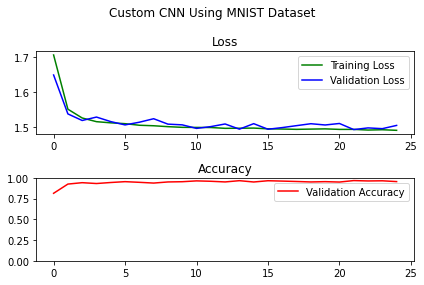

Custom CNN on MNIST dataset: 95.72% test accuracy


Beginning training on Custom2 CNN with MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.69228, Validation loss: 1.61330, Validation accuracy: 84.67%
Epoch 2/25, Training loss: 1.57328, Validation loss: 1.56075, Validation accuracy: 90.13%
Epoch 3/25, Training loss: 1.55640, Validation loss: 1.55243, Validation accuracy: 90.87%
Epoch 4/25, Training loss: 1.54679, Validation loss: 1.54696, Validation accuracy: 91.38%
Epoch 5/25, Training loss: 1.54432, Validation loss: 1.53432, Validation accuracy: 92.63%
Epoch 6/25, Training loss: 1.55072, Validation loss: 1.54166, Validation accuracy: 91.92%
Epoch 7/25, Training loss: 1.55052, Validation loss: 1.55452, Validation accuracy: 90.68%
Epoch 8/25, Training loss: 1.54792, Validation loss: 1.56280, Validation accuracy: 89.78%
Epoch 9/25, Training loss: 1.54400, Validation loss: 1.53031, Validation accuracy: 93.07%
Epoch 10/25, Train

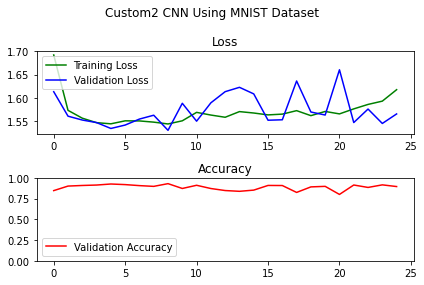

Custom2 CNN on MNIST dataset: 90.66% test accuracy




In [88]:
evalDataset(mnist_train_dl, mnist_val_dl, mnist_test_dl)

##### Train & Test Fashion MNIST

Beginning training on MLP CNN with Fashion_MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.69954, Validation loss: 1.67130, Validation accuracy: 78.98%
Epoch 2/25, Training loss: 1.65301, Validation loss: 1.64322, Validation accuracy: 81.70%
Epoch 3/25, Training loss: 1.63694, Validation loss: 1.63538, Validation accuracy: 82.53%
Epoch 4/25, Training loss: 1.63600, Validation loss: 1.65079, Validation accuracy: 80.97%
Epoch 5/25, Training loss: 1.63061, Validation loss: 1.64923, Validation accuracy: 81.08%
Epoch 6/25, Training loss: 1.62635, Validation loss: 1.62244, Validation accuracy: 83.78%
Epoch 7/25, Training loss: 1.62723, Validation loss: 1.62395, Validation accuracy: 83.67%
Epoch 8/25, Training loss: 1.62425, Validation loss: 1.62735, Validation accuracy: 83.35%
Epoch 9/25, Training loss: 1.62292, Validation loss: 1.63820, Validation accuracy: 82.25%
Epoch 10/25, Training loss: 1.62872, Validation loss: 1.65406, Val

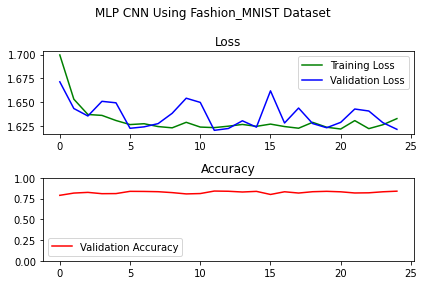

MLP CNN on Fashion_MNIST dataset: 83.51% test accuracy


Beginning training on LeNet CNN with Fashion_MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.75793, Validation loss: 1.70919, Validation accuracy: 75.32%
Epoch 2/25, Training loss: 1.67276, Validation loss: 1.65411, Validation accuracy: 80.87%
Epoch 3/25, Training loss: 1.64186, Validation loss: 1.65760, Validation accuracy: 80.30%
Epoch 4/25, Training loss: 1.62742, Validation loss: 1.62445, Validation accuracy: 83.82%
Epoch 5/25, Training loss: 1.61976, Validation loss: 1.62214, Validation accuracy: 83.93%
Epoch 6/25, Training loss: 1.61283, Validation loss: 1.61670, Validation accuracy: 84.32%
Epoch 7/25, Training loss: 1.60515, Validation loss: 1.60431, Validation accuracy: 85.65%
Epoch 8/25, Training loss: 1.60021, Validation loss: 1.60185, Validation accuracy: 85.90%
Epoch 9/25, Training loss: 1.59466, Validation loss: 1.59616, Validation accuracy: 86.48%
Epoch 1

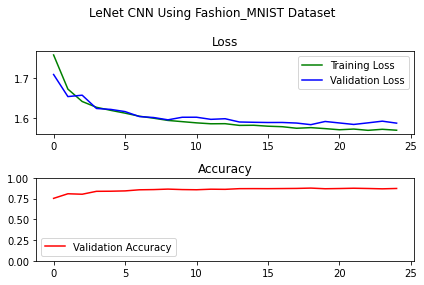

LeNet CNN on Fashion_MNIST dataset: 86.85% test accuracy


Beginning training on Custom CNN with Fashion_MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.76082, Validation loss: 1.73823, Validation accuracy: 72.28%
Epoch 2/25, Training loss: 1.73695, Validation loss: 1.74915, Validation accuracy: 71.05%
Epoch 3/25, Training loss: 1.72273, Validation loss: 1.71492, Validation accuracy: 74.62%
Epoch 4/25, Training loss: 1.70136, Validation loss: 1.70792, Validation accuracy: 75.28%
Epoch 5/25, Training loss: 1.69014, Validation loss: 1.71250, Validation accuracy: 74.85%
Epoch 6/25, Training loss: 1.69146, Validation loss: 1.69234, Validation accuracy: 76.85%
Epoch 7/25, Training loss: 1.68150, Validation loss: 1.69007, Validation accuracy: 77.05%
Epoch 8/25, Training loss: 1.67522, Validation loss: 1.69383, Validation accuracy: 76.63%
Epoch 9/25, Training loss: 1.63848, Validation loss: 1.63316, Validation accuracy: 82.77%
Epoc

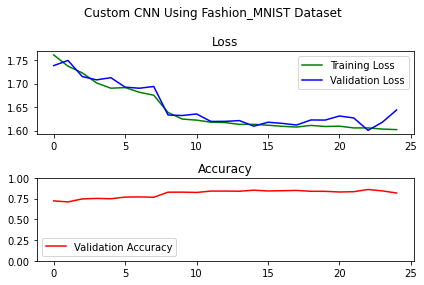

Custom CNN on Fashion_MNIST dataset: 81.37% test accuracy


Beginning training on Custom2 CNN with Fashion_MNIST dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 1.75385, Validation loss: 1.66706, Validation accuracy: 80.18%
Epoch 2/25, Training loss: 1.64636, Validation loss: 1.64805, Validation accuracy: 81.62%
Epoch 3/25, Training loss: 1.63003, Validation loss: 1.63087, Validation accuracy: 83.20%
Epoch 4/25, Training loss: 1.62039, Validation loss: 1.62467, Validation accuracy: 83.65%
Epoch 5/25, Training loss: 1.61529, Validation loss: 1.62939, Validation accuracy: 83.48%
Epoch 6/25, Training loss: 1.60889, Validation loss: 1.61502, Validation accuracy: 84.72%
Epoch 7/25, Training loss: 1.60447, Validation loss: 1.60878, Validation accuracy: 85.43%
Epoch 8/25, Training loss: 1.60080, Validation loss: 1.60484, Validation accuracy: 85.82%
Epoch 9/25, Training loss: 1.59650, Validation loss: 1.59835, Validation accuracy: 86.30%
Ep

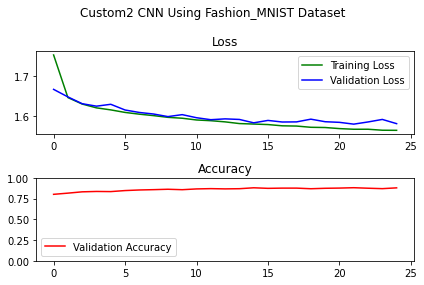

Custom2 CNN on Fashion_MNIST dataset: 87.29% test accuracy




In [89]:
evalDataset(fmnist_train_dl, fmnist_val_dl, fmnist_test_dl)

##### Train & Test CIFAR10

Beginning training on MLP CNN with CIFAR10 dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 2.13667, Validation loss: 2.12610, Validation accuracy: 32.66%
Epoch 2/25, Training loss: 2.07709, Validation loss: 2.05706, Validation accuracy: 40.06%
Epoch 3/25, Training loss: 2.05208, Validation loss: 2.05118, Validation accuracy: 40.68%
Epoch 4/25, Training loss: 2.03497, Validation loss: 2.05465, Validation accuracy: 40.24%
Epoch 5/25, Training loss: 2.02444, Validation loss: 2.03806, Validation accuracy: 41.78%
Epoch 6/25, Training loss: 2.01600, Validation loss: 2.00439, Validation accuracy: 45.28%
Epoch 7/25, Training loss: 2.00574, Validation loss: 2.01296, Validation accuracy: 44.60%
Epoch 8/25, Training loss: 2.01147, Validation loss: 2.01883, Validation accuracy: 43.96%
Epoch 9/25, Training loss: 2.00579, Validation loss: 2.02098, Validation accuracy: 43.54%
Epoch 10/25, Training loss: 1.99505, Validation loss: 2.01009, Validatio

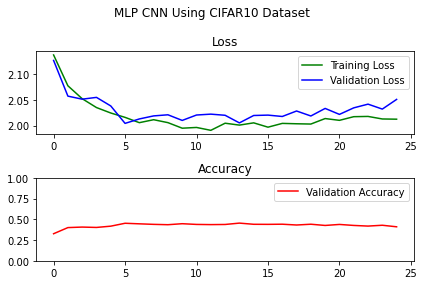

MLP CNN on CIFAR10 dataset: 40.99% test accuracy


Beginning training on LeNet CNN with CIFAR10 dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 2.12807, Validation loss: 2.07395, Validation accuracy: 37.86%
Epoch 2/25, Training loss: 2.03545, Validation loss: 2.01692, Validation accuracy: 44.14%
Epoch 3/25, Training loss: 2.00543, Validation loss: 2.00447, Validation accuracy: 44.92%
Epoch 4/25, Training loss: 1.98148, Validation loss: 1.98055, Validation accuracy: 47.44%
Epoch 5/25, Training loss: 1.96350, Validation loss: 1.97342, Validation accuracy: 48.24%
Epoch 6/25, Training loss: 1.95250, Validation loss: 1.94484, Validation accuracy: 51.28%
Epoch 7/25, Training loss: 1.94176, Validation loss: 1.95455, Validation accuracy: 50.22%
Epoch 8/25, Training loss: 1.93344, Validation loss: 1.94027, Validation accuracy: 51.74%
Epoch 9/25, Training loss: 1.92555, Validation loss: 1.93287, Validation accuracy: 52.42%
Epoch 10/25, Traini

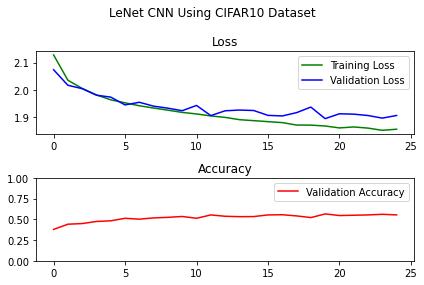

LeNet CNN on CIFAR10 dataset: 54.26% test accuracy


Beginning training on Custom CNN with CIFAR10 dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 2.10836, Validation loss: 2.09471, Validation accuracy: 36.16%
Epoch 2/25, Training loss: 2.07582, Validation loss: 2.08131, Validation accuracy: 37.70%
Epoch 3/25, Training loss: 2.06276, Validation loss: 2.08160, Validation accuracy: 37.72%
Epoch 4/25, Training loss: 2.05590, Validation loss: 2.07249, Validation accuracy: 38.62%
Epoch 5/25, Training loss: 2.05400, Validation loss: 2.06154, Validation accuracy: 39.72%
Epoch 6/25, Training loss: 2.05905, Validation loss: 2.05238, Validation accuracy: 40.80%
Epoch 7/25, Training loss: 2.05834, Validation loss: 2.03813, Validation accuracy: 42.14%
Epoch 8/25, Training loss: 2.04472, Validation loss: 2.03865, Validation accuracy: 42.14%
Epoch 9/25, Training loss: 2.04773, Validation loss: 2.05250, Validation accuracy: 40.76%
Epoch 10/25, Tra

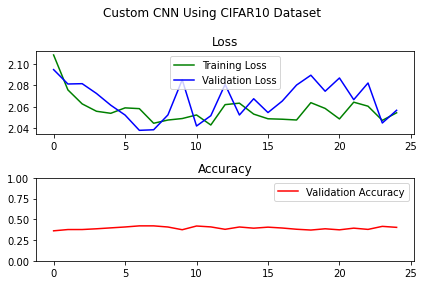

Custom CNN on CIFAR10 dataset: 40.15% test accuracy


Beginning training on Custom2 CNN with CIFAR10 dataset
Epochs: 25, Learning Rate: 0.0001
Resuming from last checkpoint...
Epoch 1/25, Training loss: 2.18477, Validation loss: 2.17810, Validation accuracy: 28.06%
Epoch 2/25, Training loss: 2.19507, Validation loss: 2.19199, Validation accuracy: 26.88%
Epoch 3/25, Training loss: 2.21096, Validation loss: 2.25282, Validation accuracy: 20.84%
Epoch 4/25, Training loss: 2.25743, Validation loss: 2.29078, Validation accuracy: 17.06%
Epoch 5/25, Training loss: 2.31381, Validation loss: 2.31693, Validation accuracy: 14.42%
Epoch 6/25, Training loss: 2.31526, Validation loss: 2.35123, Validation accuracy: 10.98%
Epoch 7/25, Training loss: 2.32695, Validation loss: 2.31392, Validation accuracy: 14.72%
Epoch 8/25, Training loss: 2.30227, Validation loss: 2.31115, Validation accuracy: 15.00%
Epoch 9/25, Training loss: 2.32826, Validation loss: 2.34235, Validation accuracy: 11.88%
Epoch 10/25, T

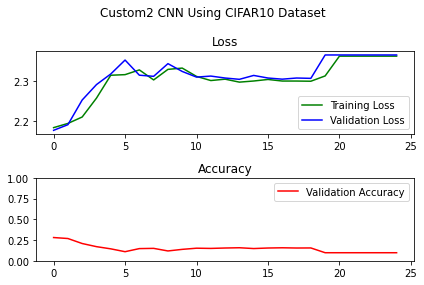

Custom2 CNN on CIFAR10 dataset: 10.00% test accuracy




In [90]:
evalDataset(cifar10_train_dl, cifar10_val_dl, cifar10_test_dl)

##### Dataset Visualizations

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


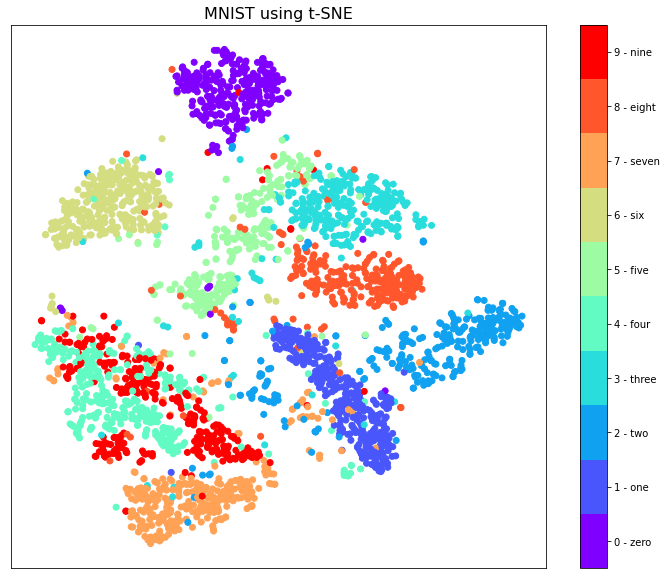

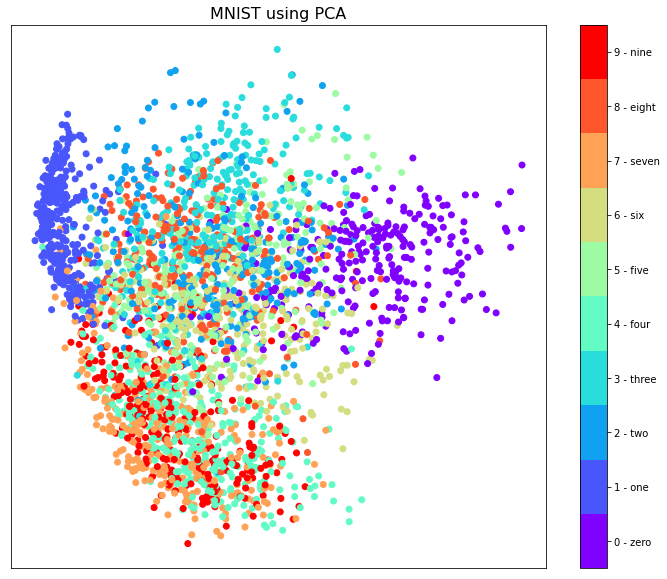

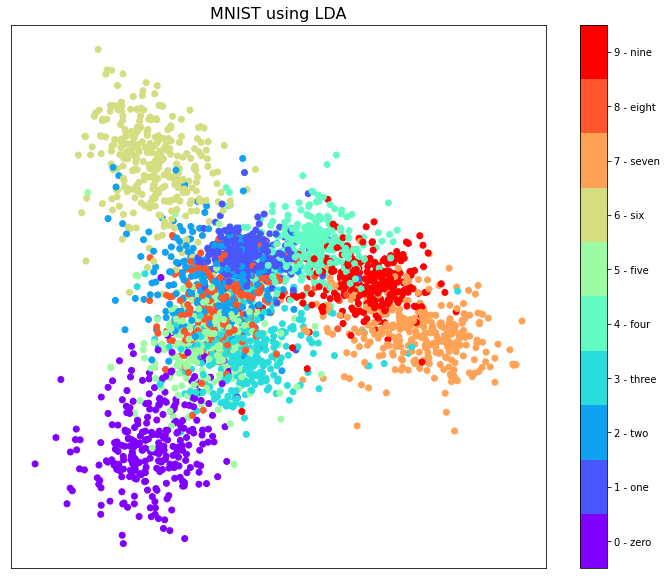

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


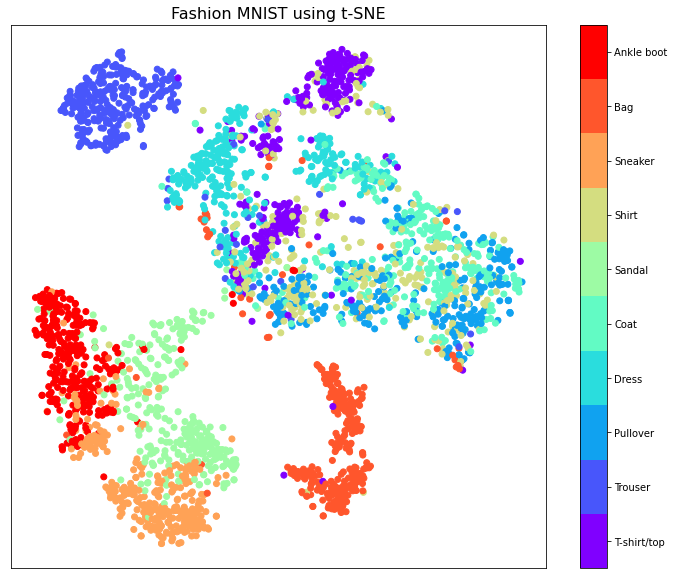

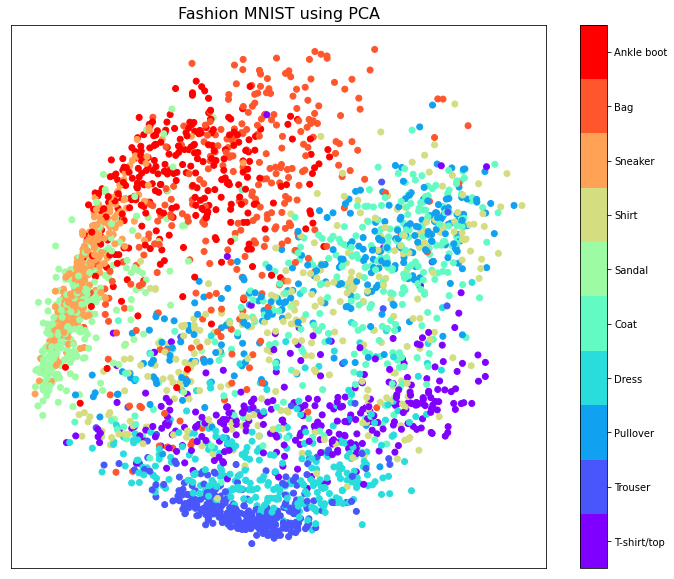

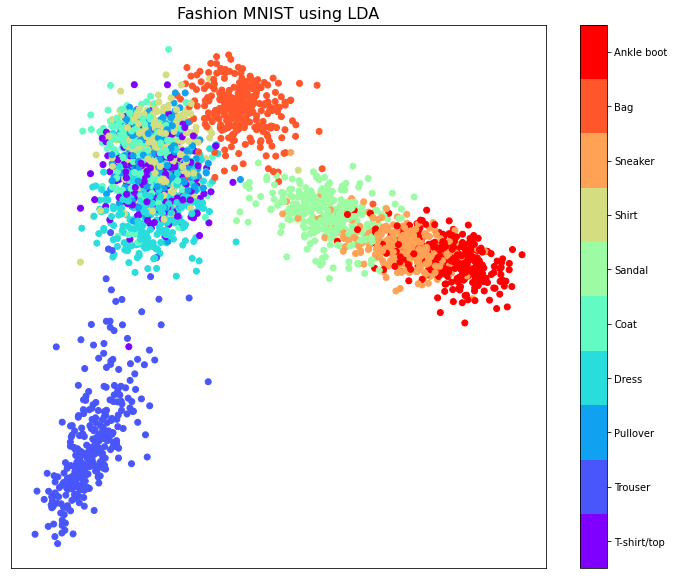

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


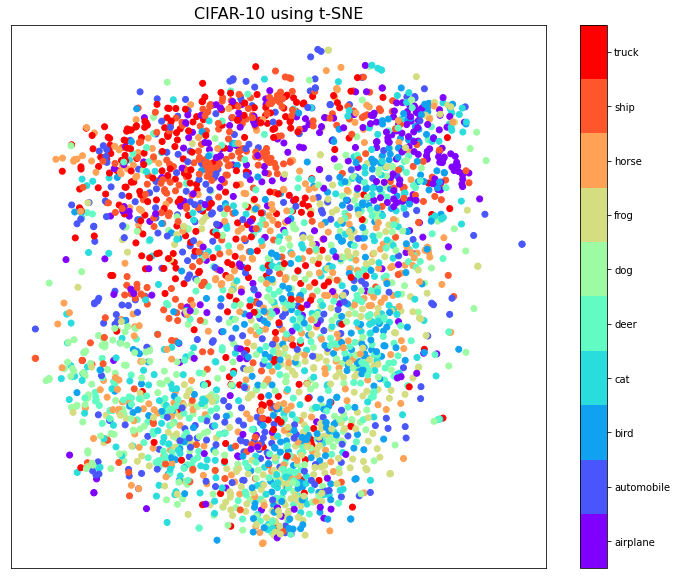

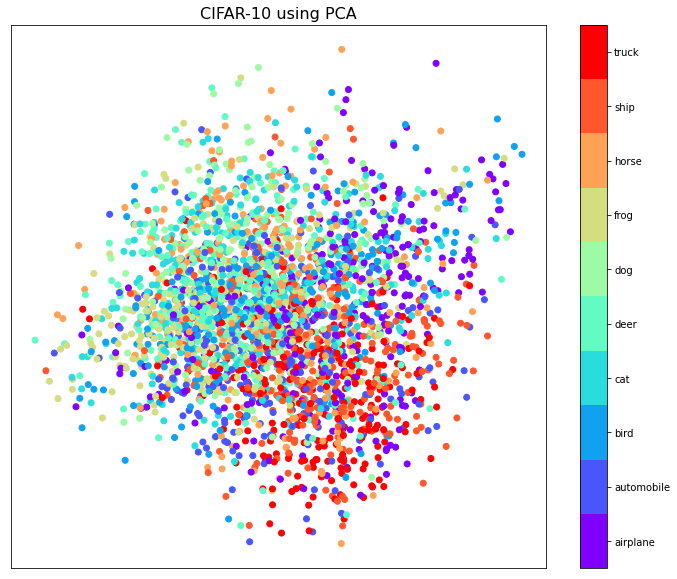

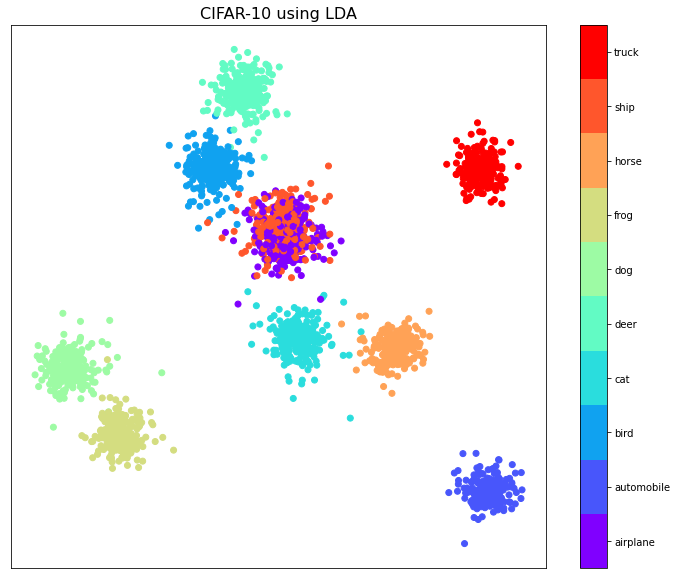

In [91]:
set_size = 3000
# Get data points from each dataset
mnist_set = mnist_raw_data.data[:set_size].reshape(set_size, 28*28)
fmnist_set = fmnist_raw_data.data[:set_size].reshape(set_size, 28*28)
cifar10_set = cifar10_raw_data.data[:set_size].reshape(set_size, 32*32*3)

# Get the labels for the data points
mnist_set_labels = mnist_raw_data.targets[:set_size]
fmnist_set_labels = fmnist_raw_data.targets[:set_size]
cifar10_set_labels = cifar10_raw_data.targets[:set_size]

# Get the classes for each dataset
mnist_classes = mnist_raw_data.classes
fmnist_classes = fmnist_raw_data.classes
cifar10_classes = cifar10_raw_data.classes

def plot(data, labels, classes, title):
  plt.figure(figsize=(12, 10))
  plt.title(title, fontsize=16)
  plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
  plt.colorbar(ticks=np.arange(10), boundaries=np.arange(11)-.5).ax.set_yticklabels(classes)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  plt.show()

def reduceDim(data, labels, classes, name):
  tsne = TSNE(n_components=2, learning_rate=200, perplexity=35, n_iter=2000)
  pca = PCA(n_components=2)
  lda = LDA(n_components=2)

  tsne = tsne.fit_transform(data)
  pca = pca.fit_transform(data)
  lda = lda.fit_transform(data, labels)

  plot(tsne, labels, classes, f'{name} using t-SNE')
  plot(pca, labels, classes, f'{name} using PCA')
  plot(lda, labels, classes, f'{name} using LDA')

reduceDim(mnist_set, mnist_set_labels, mnist_classes, 'MNIST')
reduceDim(fmnist_set, fmnist_set_labels, fmnist_classes, 'Fashion MNIST')
reduceDim(cifar10_set, cifar10_set_labels, cifar10_classes, 'CIFAR-10')